In [1]:
import astroNN
import os
import cv2
import h5py
from livelossplot import PlotLossesKeras
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup
import tensorflow_probability as tfp 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics 
from math import ceil
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import json

tfd = tfp.distributions
tfpl = tfp.layers
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
images, labels = load_galaxy10sdss()
labels = labels.astype(np.float32)
labels = to_categorical(labels)
#images = [cv2.resize(np.squeeze(image),(69,69)) for image in images]
images = np.array(images)
#images = np.array([cv2.resize(image,(32,32)) for image in images])
images = images.astype(np.float32)
images = images/255 
print(images.shape)
print(labels.shape)

C:\Users\abhim\.astroNN\datasets\Galaxy10.h5 was found!
(21785, 69, 69, 3)
(21785, 10)


In [3]:
images, labels = shuffle(images, labels, random_state=42)

In [4]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    images,
    labels,
    test_size = 0.30,
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15249, 69, 69, 3)
(15249, 10)
(3268, 69, 69, 3)
(3268, 10)
(3268, 69, 69, 3)
(3268, 10)


In [5]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

In [6]:
frequentist_model = Sequential()
frequentist_model.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Flatten())
frequentist_model.add(Dense(64, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(32, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(10, activation='softmax'))

In [7]:
frequentist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

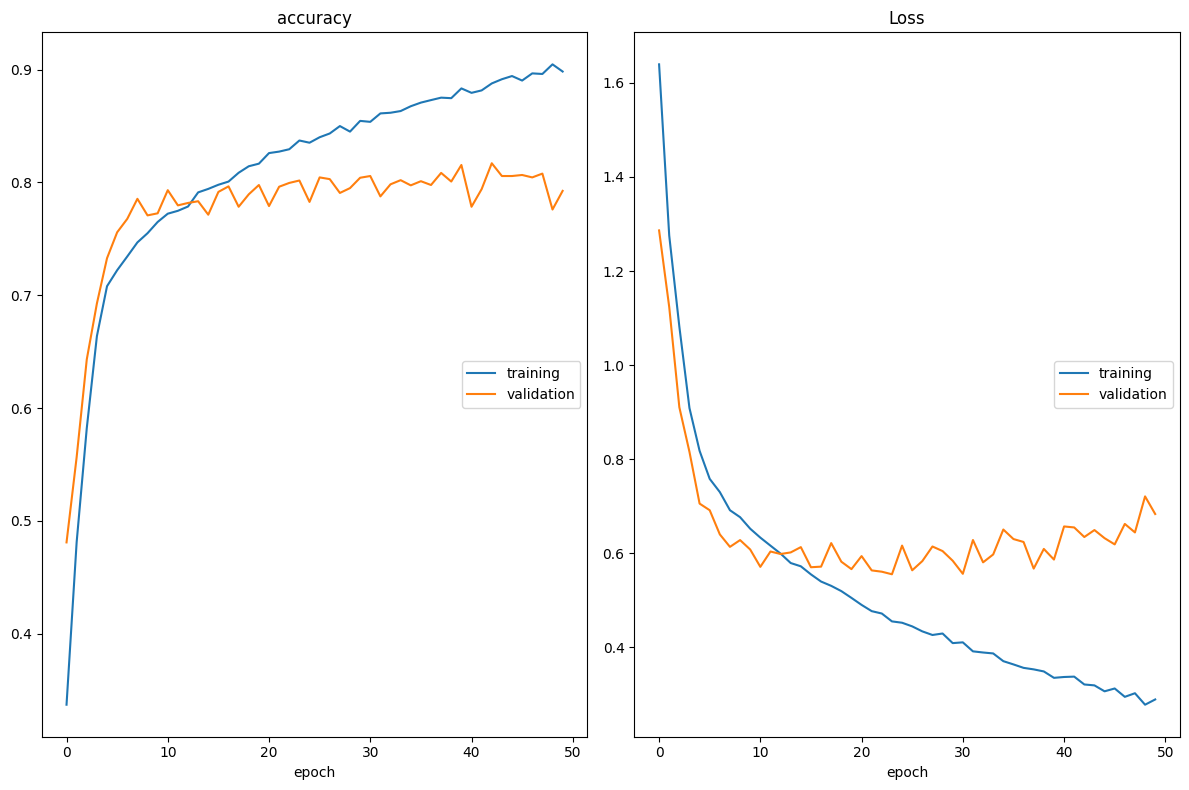

accuracy
	training         	 (min:    0.337, max:    0.905, cur:    0.898)
	validation       	 (min:    0.481, max:    0.817, cur:    0.793)
Loss
	training         	 (min:    0.278, max:    1.639, cur:    0.289)
	validation       	 (min:    0.555, max:    1.286, cur:    0.684)


In [8]:
ckpt_frequentist = tf.keras.callbacks.ModelCheckpoint(
    './checkpoints/freq_logs/best',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)
frequentist_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
frequentist_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_frequentist, PlotLossesKeras()]
)

In [8]:
bayesian_model_scratch = Sequential()
bayesian_model_scratch.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Dropout(0.4))
bayesian_model_scratch.add(Flatten())
bayesian_model_scratch.add(Dense(192, activation='relu'))
bayesian_model_scratch.add(Dropout(0.4))
bayesian_model_scratch.add(Dense(64, activation='relu'))
bayesian_model_scratch.add(Dropout(0.4))
bayesian_model_scratch.add(
    tfpl.DenseFlipout(
                 units = 10, activation = tf.nn.softmax,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
)
bayesian_model_scratch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)         

c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.


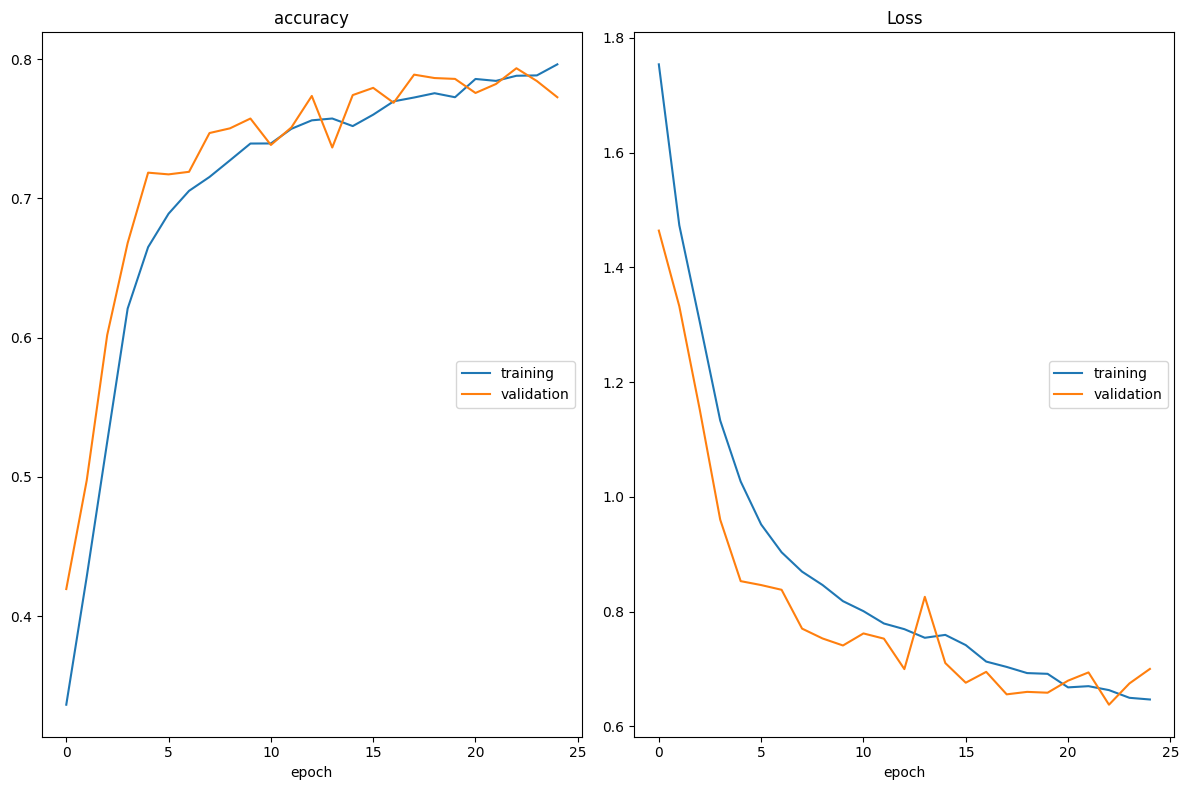

accuracy
	training         	 (min:    0.336, max:    0.796, cur:    0.796)
	validation       	 (min:    0.420, max:    0.793, cur:    0.773)
Loss
	training         	 (min:    0.647, max:    1.754, cur:    0.647)
	validation       	 (min:    0.638, max:    1.464, cur:    0.700)


In [48]:
ckpt_bayes = tf.keras.callbacks.ModelCheckpoint(
    './checkpoints/baye_logs/best',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)
bayesian_model_scratch.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
bayesian_model_scratch.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_bayes, PlotLossesKeras()]
)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

frequentist_model.load_weights('./checkpoints/freq_logs/best')
bayesian_model_scratch.load_weights('./checkpoints/baye_logs/best')
y_pred_standard = frequentist_model.predict(X_test)
y_pred_bayesian_scratch = bayesian_model_scratch.predict(X_test)
print("Standard Model AUC:", roc_auc_score(y_test, y_pred_standard))
print("Bayesian Model Scratch AUC:", roc_auc_score(y_test, y_pred_bayesian_scratch))

print(classification_report(y_test.argmax(axis=1), y_pred_standard.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), y_pred_bayesian_scratch.argmax(axis=1)))

Standard Model AUC: 0.9655699511116935
Bayesian Model Scratch AUC: 0.9671136235405775
              precision    recall  f1-score   support

           0       0.62      0.43      0.51       489
           1       0.92      0.93      0.93      1068
           2       0.84      0.94      0.89       980
           3       0.67      0.48      0.56        58
           4       0.86      0.89      0.87       237
           5       0.00      0.00      0.00         2
           6       0.74      0.69      0.72        78
           7       0.50      0.74      0.60       147
           8       0.40      0.48      0.44       127
           9       0.80      0.39      0.52        82

    accuracy                           0.80      3268
   macro avg       0.64      0.60      0.60      3268
weighted avg       0.80      0.80      0.79      3268

              precision    recall  f1-score   support

           0       0.65      0.48      0.55       489
           1       0.91      0.97      0.94   

c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit